# <i>Survival Analysis IV</i>
## <i>Parametric Survival Analysis</i>

Parametric models are used when the survival time follows a known analytical distribution. Compared to the Cox model, they have the advantage of a completely specified $h(t)$ and $S(t)$, but also the strong assumption of an underlying distribution.

An example, and popular choice, is the Weibull model. Its survival function looks like:

<h2>$S(t) = exp \left( - \left( \frac{t}{\lambda} \right)^{\rho} \right), \lambda \gt 0, \rho \gt 0$</h2>

We use the data to estimate the parameters of $\lambda$ and $\rho$, and estimate the cumulative hazard.

There are many other parametric models available in lifelines:
    
<img src="img/functions_table.png" style="height: 250px; width: auto;">

The lifelines documentation points out that many of these models are a special case of the generalized Gamma model, which takes on a complicated form:

<h2>$
\begin{split}S(t)=\left\{  \begin{array}{}
   1-\Gamma_{RL}\left( \frac{1}{{{\lambda }^{2}}};\frac{{e}^{\lambda \left( \frac{\log(t)-\mu }{\sigma} \right)}}{\lambda ^{2}} \right)  \textit{ if } \lambda> 0 \\
      \Gamma_{RL}\left( \frac{1}{{{\lambda }^{2}}};\frac{{e}^{\lambda \left( \frac{\log(t)-\mu }{\sigma} \right)}}{\lambda ^{2}} \right)  \textit{ if } \lambda \le 0 \\
\end{array} \right.\,\!\end{split}
$</h2>

$\Gamma_{RL}$ is the regularized lower incomplete Gamma function, the definition of which is beyond the scope of this writing.

- When $\lambda = 1$ and $\sigma = 1$, the distribution is Exponential
- When $\lambda = 1$, the distribution is Weibull
- When $\sigma = \lambda$, the distribution is Gamma
- When $\lambda = 0$, the distribution is Log-Normal
- When $\lambda = -1$, the distribution is Inverse-Weibull
- When $\sigma = -\lambda$, the distribution is Inverse-Gamma

### Import Libraries and Data

In [1]:
import lifelines
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

data = lifelines.datasets.load_gbsg2()
print(np.shape(data))
data.head()

(686, 10)


,horTh,age,menostat,tsize,tgrade,pnodes,progrec,estrec,time,cens
0,no,70,Post,21,II,3,48,66,1814,1
1,yes,56,Post,12,II,7,61,77,2018,1
2,yes,58,Post,35,II,9,52,271,712,1
3,yes,59,Post,17,II,4,60,29,1807,1
4,no,73,Post,35,II,1,26,65,772,1


### Preprocessing

We'll preprocess the data, as several of the fields have text values.

In [2]:
data['horTh'] = data['horTh'].map({'no': 0, 'yes': 1})
data['menostat'] = data['menostat'].map({'Pre': 0, 'Post': 1})

dummies = pd.get_dummies(data['tgrade'], drop_first=True)
data = pd.concat([data, dummies], axis=1)
data.drop(columns=['tgrade'], inplace=True)
data = data.rename(columns={'II': 'tgrd2', 'III': 'tgrd3'})
data.head(2)

,horTh,age,menostat,tsize,pnodes,progrec,estrec,time,cens,tgrd2,tgrd3
0,0,70,1,21,3,48,66,1814,1,1,0
1,1,56,1,12,7,61,77,2018,1,1,0


### Weibull Model

We'll arbitrarily pick a Weibull model to fit to the dataset. As mentioned above, the survival function is:

$S(t) = \exp\left(-\left(\frac{t}{\lambda}\right)^\rho\right),   \lambda >0, \rho > 0$

It has parameters $\lambda$ and $\rho$, which are determined automatically if left blank, and will vary by dataset.

<lifelines.WeibullFitter:"Weibull_estimate", fitted with 686 total observations, 387 right-censored observations>
   number of observations = 686
number of events observed = 299
           log-likelihood = -2637.28
               hypothesis = lambda_ != 1, rho_ != 1

---
           coef   se(coef)   coef lower 95%   coef upper 95%
lambda_ 2259.85     114.89          2034.68          2485.03
rho_       1.27       0.06             1.15             1.40

          cmp to     z      p   -log2(p)
lambda_     1.00 19.66 <0.005     283.48
rho_        1.00  4.29 <0.005      15.78
---
AIC = 5278.55

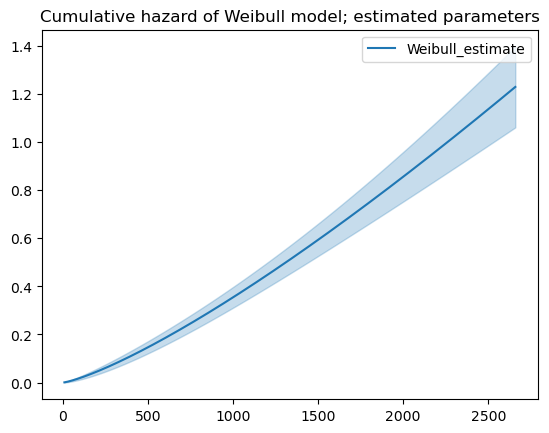

In [3]:
from lifelines import WeibullFitter

wf = WeibullFitter().fit(data['time'], data['cens'])

wf.print_summary()
ax = wf.plot_cumulative_hazard();
ax.set_title("Cumulative hazard of Weibull model; estimated parameters");

We can view the lambda and rho values as follows:

In [4]:
print('lambda:', wf.lambda_)
print('rho:', wf.rho_)

lambda: 2259.852517103214
rho: 1.2715194827476686


To demonstrate that the optimal lambda and rho varies by dataset, here are the parameter values found for the lifelines 'Waltons' data set.

lambda: 55.733096995296066
rho: 3.4505054112456808


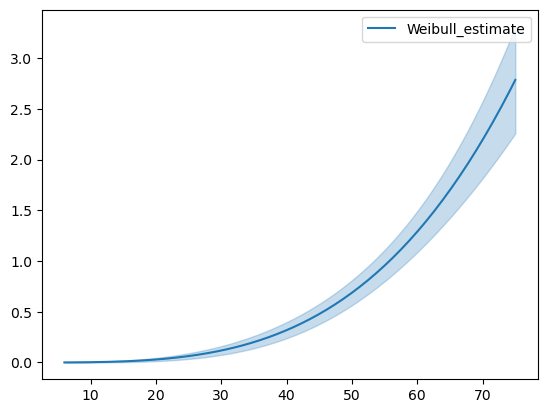

In [5]:
from lifelines import WeibullFitter
from lifelines.datasets import load_waltons
waltons = load_waltons()
wbf = WeibullFitter()
wbf.fit(waltons['T'], waltons['E'])
wbf.plot()
print('lambda:', wbf.lambda_)
print('rho:', wbf.rho_)

Below plots the Wiebull based survival function of the breast cancer dataset.

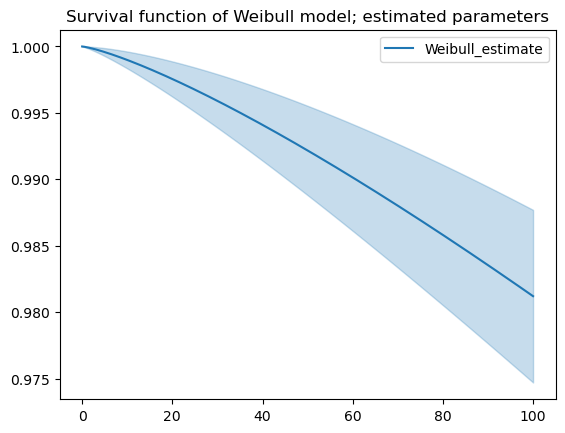

In [6]:
T = data['time']
E = data['cens']

timeline = np.linspace(0, 100, 200)

# directly compute the survival function, these return a pandas Series
wbf = WeibullFitter().fit(T, E)
wbf.survival_function_at_times(timeline)
wbf.hazard_at_times(timeline)
wbf.cumulative_hazard_at_times(timeline)

# use the `timeline` kwarg in `fit`
# by default, all functions and properties will use
# these values provided
wbf = WeibullFitter().fit(T, E, timeline=timeline)

ax = wbf.plot_survival_function()
ax.set_title("Survival function of Weibull model; estimated parameters");

Below shows a subplot of the various curves discovered from the breast cancer data, as determined by the parameters set or found.

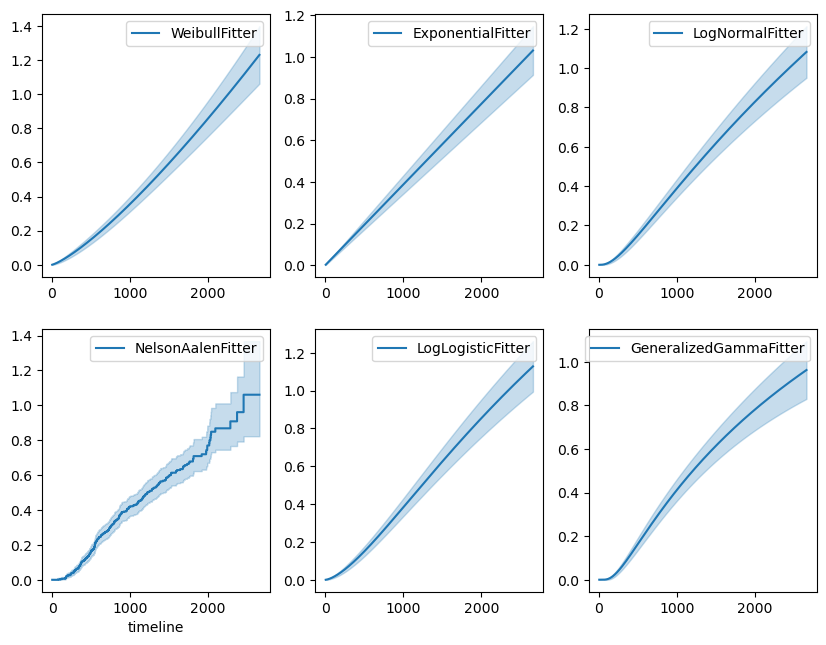

In [7]:
from lifelines import (WeibullFitter, ExponentialFitter,
LogNormalFitter, LogLogisticFitter, NelsonAalenFitter, GeneralizedGammaFitter)

fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))

T = data['time']
E = data['cens']

wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
naf = NelsonAalenFitter().fit(T, E, label='NelsonAalenFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')

wbf.plot_cumulative_hazard(ax=axes[0][0])
exf.plot_cumulative_hazard(ax=axes[0][1])
lnf.plot_cumulative_hazard(ax=axes[0][2])
naf.plot_cumulative_hazard(ax=axes[1][0])
llf.plot_cumulative_hazard(ax=axes[1][1])
gg.plot_cumulative_hazard(ax=axes[1][2]);

<ul>
    <li>WeibullFitter has the parameters <code>lambda_</code> and <code>rho_</code></li>
    <li>ExponentialFitter has the parameter <code>lambda_</code></li>
    <li>LogNormalFitter has the parameters <code>mu_</code> and <code>sigma_</code></li>
    <li>LogLogisticFitter has parameters <code>alpha_</code> and <code>beta_</code></li>
    <li>GeneralizedGammaFitter has parameters <code>lambda_</code>, <code>rho_</code>, and <code>alpha_</code></li>

The absence of the Kaplan-Meier model is because it is not used to model the hazard function. But we can include it when viewing survival functions.

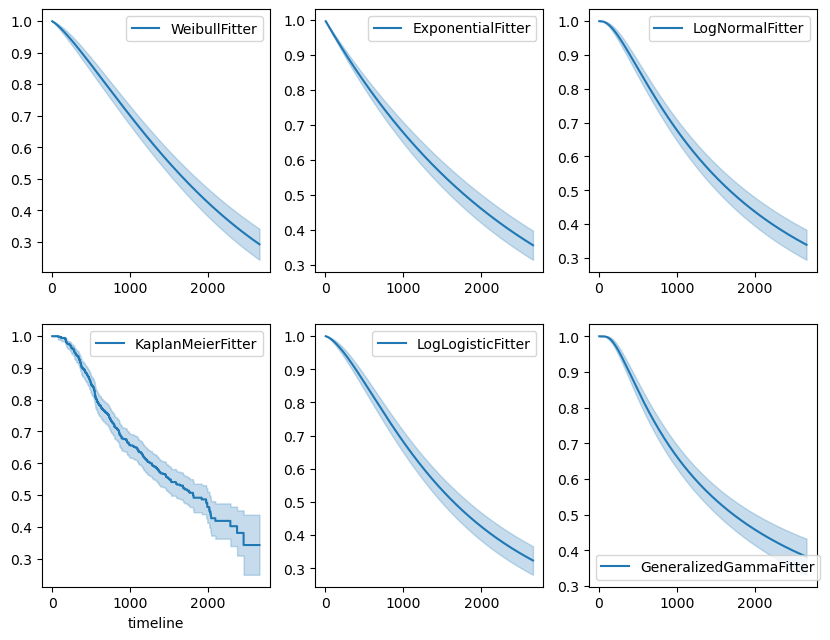

In [8]:
from lifelines import KaplanMeierFitter

fig, axes = plt.subplots(2, 3, figsize=(10, 7.5))

kmf = KaplanMeierFitter().fit(T, E, label='KaplanMeierFitter')
wbf = WeibullFitter().fit(T, E, label='WeibullFitter')
exf = ExponentialFitter().fit(T, E, label='ExponentialFitter')
lnf = LogNormalFitter().fit(T, E, label='LogNormalFitter')
llf = LogLogisticFitter().fit(T, E, label='LogLogisticFitter')
gg = GeneralizedGammaFitter().fit(T, E, label='GeneralizedGammaFitter')

wbf.plot_survival_function(ax=axes[0][0])
exf.plot_survival_function(ax=axes[0][1])
lnf.plot_survival_function(ax=axes[0][2])
kmf.plot_survival_function(ax=axes[1][0])
llf.plot_survival_function(ax=axes[1][1])
#pwf.plot_survival_function(ax=axes[1][2])
gg.plot_survival_function(ax=axes[1][2]);
# spf.plot_survival_function(ax=axes[2][1])

### <code>find_best_parametric_model</code>

Lifelines offers a tool to search parametric parameters and models, and return the best fitting model, according to the AIC (Akaike Information Criterion) or BIC (Bayes Information Criterion).

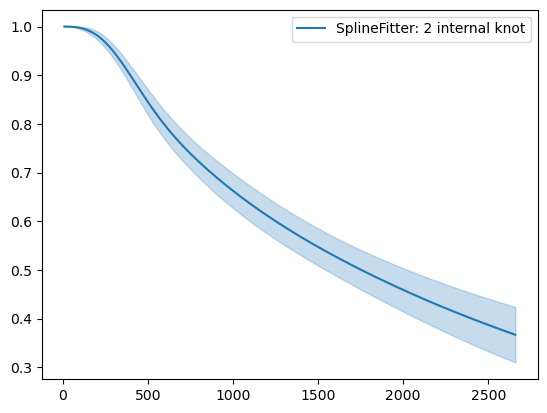

In [9]:
from lifelines.utils import find_best_parametric_model
best_model, best_aic_ = find_best_parametric_model(T, E, scoring_method="AIC")
best_model.plot_survival_function();

### The Akaike Information Criterion (AIC)

The AIC is equal to:

$AIC = 2k - 2 ~ln(\mathcal{L})$

where $k$ is the number of parameters, and $\mathcal{L}$ is the maximimum of the likelihood function of the model. This penalizes the model's performance for having additional parameters.

<b>Source: https://towardsdatascience.com/the-akaike-information-criterion-c20c8fd832f2</b>

# Accelerated Failure Time (AFT) Model

A way of comparing a treatment group to a control group, often used with parametric distributions, is the AFT model. It assumes that survival functions derived from two populations $P$ and $Q$ are related by an acceleration factor $\lambda$, which can be modelled as a function of covariates. A commonly cited example is that humans tend to survive about 7 times longer than dogs.

<h2>$S_P(t) = S_Q(t) \left( \frac{t}{\lambda(x)} \right)$</h2>

<h2>$\lambda(x) = exp(\beta_0 + \sum_{i=1}^n \beta_i x_i)$</h2>

The AFT model can accelerate or decelerate the relative failure times. The model coefficients are interpreted as: a unit increase in covariate means the average or median survival time changes by a factor of $exp(\beta_i)$. 

It is commonly paired with distributions such as the Weibull, exponential, log-normal, log-logistic, and generalized gamma, and this is how we see it in lifelines. There are various distributions that you can associate with your AFT model.

The below compares various AFT models, and returns the concordance index of each for comparability.

In [13]:
from lifelines import KaplanMeierFitter, WeibullAFTFitter, LogNormalAFTFitter, LogLogisticAFTFitter

aft = WeibullAFTFitter()
aft.fit(data, 'time', 'cens') #, ancillary=data)
aft.predict_median(data)
print('Weibull AFT:', round(aft.concordance_index_,4))

aft = LogNormalAFTFitter()
aft.fit(data, 'time', 'cens') #, ancillary=data)
aft.predict_median(data)
print('LogNormal AFT:', round(aft.concordance_index_,4))

aft = LogLogisticAFTFitter()
aft.fit(data, 'time', 'cens') #, ancillary=data)
aft.predict_median(data)
print('LogLogisticAFTFitter:', round(aft.concordance_index_,4))

Weibull AFT: 0.6918
LogNormal AFT: 0.6937
LogLogisticAFTFitter: 0.6944


### Concordance Index

The concordance index is defined as the proportion of concordant pairs divided by the total number of possible evaluation pairs, and more can be read about it here:

https://medium.com/analytics-vidhya/concordance-index-72298c11eac7

# What Next?

What you may have noticed between the first article and this one (if you've followed along) is that I mentioned the scikit-survival package in the beginning, and have ignored it since the data gathering phase.

Whereas the lifelines documentation I've drawn from is focused on essential knowledge, it includes features such as time-variant analysis of hazard and survival functions, and the scikit-survival package takes things further by providing functions and documentation such as random survival forests, and survival support vector machines (SVMs). Modern literature and experimentation takes it even further.

Though I may write about more advanced techniques for survival analysis in the future, I will end this series of articles, and I hope that if you had little knowledge of the subject before, that you have found them useful and/or inspiring.


# References

1. (n.d.). Lifelines Documentation. Lifelines. https://lifelines.readthedocs.io/en/latest/
2. Moore, D. F. (2016). Applied Survival Analysis in R. Springer International Publishing Switzerland 2016.
3. (n.d.). Scikit-Survival Documentation. https://scikit-survival.readthedocs.io/en/stable/user_guide/index.html
4. [Udemy]. (2019, April 1). Survival Analysis in R [Video]. Udemy. https://www.udemy.com/course/survival-analysis-in-r/
5. (2019, January 6). Survival Analysis Intuition and Implementation in Python. Towards Data Science. https://towardsdatascience.com/survival-analysis-intuition-implementation-in-python-504fde4fcf8e
6. Lewinson, E. (2020, August 17). Introduction to Survival Analysis: The Kaplan-Meier estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-kaplan-meier-estimator-94ec5812a97a
7. Lewinson, E. (2020, July 23). The Cox Proportional Hazards Model. Towards Data Science. https://towardsdatascience.com/the-cox-proportional-hazards-model-35e60e554d8f
8. Lewinson, E. (2020, August 23). Introduction to Survival Analysis: The Nelson-Aalen estimator. Towards Data Science. https://towardsdatascience.com/introduction-to-survival-analysis-the-nelson-aalen-estimator-9780c63d549d